In [1]:
# import libraries 
import pandas as pd
import sys
from pathlib import Path
from groq import Groq
from tqdm import tqdm
import time
import seaborn as sns
import matplotlib.pyplot as plt



# Add 'src' to the system path
sys.path.append(str(Path().resolve() / 'src'))

In [2]:
df_movies = pd.read_csv('data/processed/movies.csv')
df_plots = pd.read_csv('data/processed/plot_summaries.csv')
# merge movie metadata and plots 
df_movies_summaries = pd.merge(df_movies, df_plots, on='Wikipedia movie ID')


df_movies_summaries = df_movies_summaries.head(100)
df_movies_summaries

,Wikipedia movie ID,Freebase ID,Movie name,Release date,Box office revenue,Runtime,Languages,Countries,Genres,Summary
0,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",A series of murders of rich young women throug...
1,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}","Eva, an upper class housewife, becomes frustra..."
2,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","{""/m/0hqxf"": ""Family Film"", ""/m/01hmnh"": ""Fant...","Every hundred years, the evil Morgana returns..."
3,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hj3n0w"": ...","Adam, a San Francisco-based artist who works a..."
4,171005,/m/016ywb,Henry V,1989-11-08,10161099.0,137.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/04xvh5"": ""Costume drama"", ""/m/082gq"": ""Wa...",{{Plot|dateAct 1Act 2Act 3Act 4Act 5 Finally n...
...,...,...,...,...,...,...,...,...,...,...
95,33956317,/m/0hndjzb,The Catastrophe,NaN,NaN,15.0,{},{},"{""/m/02hmvc"": ""Short Film"", ""/m/07s9rl0"": ""Dra...",The Catastrophe is a surreal drama/mystery sho...
96,336846,/m/01xlqd,Grease,1978-06-16,394589888.0,225.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06cvj"": ""Romantic comedy"", ""/m/0hn10"": ""L...","In the summer of 1959, local boy Danny Zuko a..."
97,27463222,/m/0c037x9,Vanishing on 7th Street,2010-09-12,NaN,92.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/03npn"": ""Horror""...",Paul is a projectionist in a Detroit theater ...
98,3249964,/m/0917bx,House by the River,1950-03-25,NaN,85.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/03npn"": ""Hor...","A rich novelist, Stephen Byrne, who lives and ..."


# Example with one plot
We will try to extract the perception (negative : -1, neutral/absent : 0, positive :1) of 3 countries in a plot.

In [3]:
plot = df_movies_summaries['Summary'][8]
plot

'Otto Brosowski, a communist miner, writes to the miners in the Soviet city of Krivoy Rog, telling them of the harsh conditions in which he and his friends work, as the capitalist owners of the copper mine demand harder work. He receives a Red Banner from them. As the Nazis seize power, Otto and his family hide the flag from the authorities, taking great personal risks. At 1945, as the Second World War nears its end, the town is occupied by the Americans, who also wish to steel the Banner. At July 1945, as the Americans retreat and allow the Red Army to take over the area, the Brosowski family takes the flag and heads to meet the Soviets.'

This dictionnary format is the way we ask the llm to treat the data.
We give it all our criterions. The key "type" can lead to 2 modes : "score" (give a score from -1 to 1) or a list of predicates (ex. : ["Russia", "Germany", "Japan"] from which to choose the more appropriates - this is untested).

In [4]:
descriptors = {
    "usa_goodness": {
        "goal": "determine if the USA is portrayed in a positive light. USA is here a global concept, not just the exact country",
        "type": "score"
    },
    "russia_goodness": {
        "goal": "determine if Russia is portrayed in a positive light. Russia is here a global concept, not just the exact country",
        "type": "score"
    },
    "germany_goodness": {
        "goal": "determine if Germany is portrayed in a positive light. Germany is here a global concept, not just the exact country",
        "type": "score"
    }
}

The main function ! It's an abstraction

In [ ]:
client = Groq(api_key="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")
# ONLY TO FACILITATE LIVE CODING AND SHARING
# OK BECAUSE ON FREE PLAN WITH NO CREDIT CARD
# TO REMOVE LATER

def get_description(plot, descriptors):
    description = {}

    for feature_name, feature_description in descriptors.items():
        goal = feature_description["goal"]
        type_info = feature_description["type"]

        # Frame the query based on type, including the plot for context
        if type_info == "score":
            query = f"Based on the following plot: '{plot}', {goal}. Provide a numeric score between - 1 and 1. -Here, 0 is the expected value when you cannot decide. Do not go beyond or below this range. Return only a number. Example of a valid response: 0.6. Example of an invalid response : the answer is 0.5"
            try:
                chat_completion = client.chat.completions.create(
                    messages=[{"role": "user", "content": query}],
                    model="llama3-8b-8192",
                )
                # Extract response
                groq_response = chat_completion.choices[0].message.content
                # Convert response to float and clamp to the specified range
                vector = float(groq_response)
            except Exception as e:
                vector = None

        elif isinstance(type_info, list):
            options = ", ".join(type_info)
            query = f"Based on the following plot: '{plot}', {goal}. Choose one or more categories from the following options: {options}."
            try:
                chat_completion = client.chat.completions.create(
                    messages=[{"role": "user", "content": query}],
                    model="llama3-8b-8192",
                )
                # Extract response
                groq_response = chat_completion.choices[0].message.content
                # Filter response to match only the provided list options
                vector = [item.strip() for item in groq_response.split(',') if item.strip() in type_info]
            except Exception as _:
                vector = None

        # Pause for 2 seconds to ensure max rate is not exceeded (30/min + 15 000 tokens)
        time.sleep(2)
        description[feature_name] = vector

    return description

In [6]:
description = get_description(plot, descriptors)
description

{'usa_goodness': None, 'russia_goodness': 0.6, 'germany_goodness': -0.8}

In [7]:
df_movies_us_vs_ussr = pd.DataFrame(columns=['Movie Name', 'Summary', 'USA', 'Russia', 'Germany', 'Release date'])

# Loop through each movie summary in the original DataFrame
rows = []
for index, row in tqdm(df_movies_summaries.iterrows(), total=df_movies_summaries.shape[0]):
    movie_name = row['Movie name']  # Get the movie name
    plot = row['Summary']  # Get the movie summary
    movie_date = row['Release date']  # Get the movie date
    description = get_description(plot, descriptors)  # Get USA and USSR scores
    
    # Add a new row to the list
    rows.append({
        'Movie Name': movie_name,
        'Summary': plot,
        'Release date': movie_date,
        'USA': description['usa_goodness'],
        'USSR': description['russia_goodness'],
        'Germany': description['germany_goodness']
    })

# Create a new DataFrame from the list of rows
df_movies_us_vs_ussr = pd.DataFrame(rows)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [11:39<00:00,  6.99s/it]


c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\nicol\AppData\Local\Programs\Python\Python39\lib\site-packa

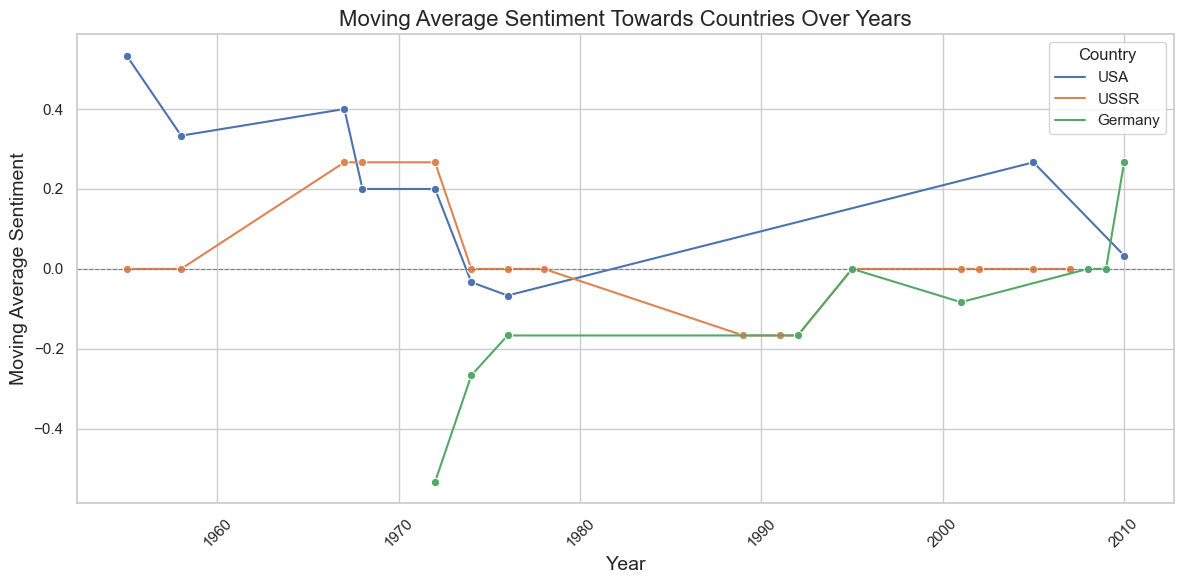

In [8]:
# Process the Release date to extract valid years
def extract_year(release_date):
    try:
        if isinstance(release_date, str):
            # Handle cases like "2022" and "2022/22/10"
            if len(release_date) == 4 and release_date.isdigit():  # e.g., "2022"
                return int(release_date)
            elif '/' in release_date:
                return int(release_date.split('/')[0])  # Get the year part
        return None  # Drop non-year or invalid formats
    except Exception as _:
        return None

# Apply the function to extract years and create a new column
df_movies_us_vs_ussr['Year'] = df_movies_us_vs_ussr['Release date'].apply(extract_year)

# Drop rows with NaN in 'Year' column (invalid years)
df_movies_us_vs_ussr = df_movies_us_vs_ussr.dropna(subset=['Year'])

# Group by year and calculate the average sentiment for each country
avg_sentiment_by_year = df_movies_us_vs_ussr.groupby('Year')[['USA', 'USSR', 'Germany']].mean().reset_index()

# Calculate the moving average for each country's sentiment
moving_average_sentiment = avg_sentiment_by_year.copy()
moving_average_sentiment[['USA', 'USSR', 'Germany']] = moving_average_sentiment[['USA', 'USSR', 'Germany']].rolling(window=3).mean()

# Set up the Seaborn style
sns.set(style="whitegrid")

# Melt the DataFrame to long format for easier plotting with Seaborn
melted_sentiment = moving_average_sentiment.melt(id_vars='Year', value_vars=['USA', 'USSR', 'Germany'],
                                                  var_name='Country', value_name='Moving Average Sentiment')

# Create the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_sentiment, x='Year', y='Moving Average Sentiment', hue='Country', marker='o')

# Customize the plot
plt.title('Moving Average Sentiment Towards Countries Over Years', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Moving Average Sentiment', fontsize=14)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Optional: horizontal line at y=0
plt.legend(title='Country')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Show the plot
plt.show()

A few problems :
- Slow : limited to 30 requests/min& 15 000 tokens/min. 
- Capacity : limited to 500k tokens/day; so around 500 movies for 3 criterions.


To get 50 000 movies on 10 criterions it would take 333 days. 